In [1]:
import os
import re
import http
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import quote
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from matplotlib.dates import DateFormatter
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta
from IPython.display import clear_output

In [2]:
import pandas as pd

results = list(pd.read_csv("results.csv", sep = ';')["Слово"])

In [3]:
with open("inverted_index.pkl", "rb") as file:
    inverted_index = pickle.load(file)

Так как даже очень частотные слова не встречаются в корпусе каждый день, график встречаемости слов, построенный с учётом каждого дня, был бы слишком рваным и не дал бы нужной информации. Необходимо выполнить сглаживание -- например, считать вхождения не для каждого дня, а для каждого месяца.

In [4]:
# Функция, получающая на вход список дат и возвращающая список длиной n,
# где n -- количество месяцев от start_date до end_date,
# в котором i-тое значение -- количество вхождений слова за i-тый месяц.
# Так как объект timedelta не имеет атрибута months (только days, seconds и microseconds),
# индекс каждого месяца придётся считать вручную.
def smoothing(word):
    dates = inverted_index[word]
    new_dates = [0 for i in range(228)]
    # между 01.01.2000 и 01.01.2019 всего прошло 19 * 12 = 228 месяцев.
    for date in dates:
        index = 12 * (date.year - 2000) + date.month - 1
        # Считаем индекс текущего месяца
        # если январь 2000 года имеет индекс 0, а декабрь 2018 -- 227.
        new_dates[index] += 1
    return (new_dates)

In [5]:
def daterange_months(start_date):
    # вспомогательная функция, упрощающая итерацию по месяцам
    for n in range(228):
        yield start_date + relativedelta(months=n)

In [6]:
# список всех месяцев от января 2000 года до декабря 2019 года
dates = [date for date in daterange_months(date(2000, 1, 1))]
formatter = DateFormatter('%m/%Y')

# функция, строящая график встречаемости слова.
def plot_by_month(word):
    x = smoothing(word)
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(dates, x)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title(word)
    plt.show()

In [6]:
# Попробуем построить график встречаемости случайного достаточно частотного слова.
word = random.choice(list(inverted_index.keys()))
print(f"{word}: {inverted_index[word]}")

зиглера: [datetime.date(2002, 7, 10), datetime.date(2005, 10, 14), datetime.date(2005, 10, 14), datetime.date(2007, 6, 18), datetime.date(2007, 6, 18), datetime.date(2007, 6, 18), datetime.date(2009, 2, 9), datetime.date(2011, 7, 26), datetime.date(2016, 8, 23)]


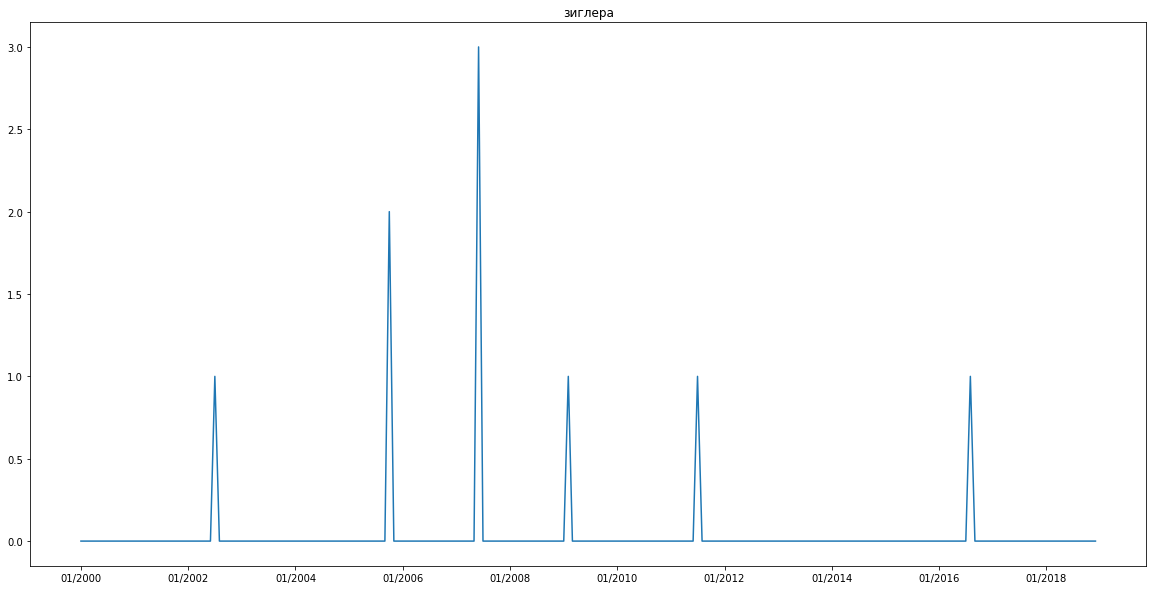

In [7]:
plot_by_month(word)
# график всё ещё рваный, но уже меньше
# применить методы сглаживания, имеющиеся в библиотеке scipy,
# не позволяло то, что по оси x лежат даты в формате datetime.date

Будем считать словами с короткой историей слова, год появления которых >= 2002, а год исчезновения <= 2017. Исключим слова, у которых < 5 вхождений и слова, написанные латиницей. Кроме того, сделаем дополнительную проверку на то, является ли слово именованной сущностью (т. к., библиотека NER часто пропускает именованные сущности) -- проверим, имеется ли посвящённая слову страница в википедии.

In [8]:
def download_page(pageUrl):
    # функция, скачивающая страницу
    req = Request(url=pageUrl)
    try:
        page = urlopen(req).read()
    except (http.client.IncompleteRead) as e:
        page = e.partial
    except:
        page = "error"
    return page

In [9]:
common_url = "https://ru.wikipedia.org/wiki/"

def is_wiki_page(word):
    page = BeautifulSoup(download_page(common_url + quote(word)), "html.parser")
    return(page != "error" and page.find("div", {"class": "mw-normal-catlinks"}) is not None)

In [10]:
results = []

In [11]:
for word in inverted_index.keys():
    if len(inverted_index[word]) >= 5 \
    and inverted_index[word][0].year >= 2002 \
    and inverted_index[word][-1].year <= 2017 \
    and not bool(re.search('[^а-яА-Я]', word)):
        results.append(word)

In [12]:
for word in results:
    print(word)
    if is_wiki_page(word) is True:
        results.remove(word)
    clear_output()

In [13]:
len(results)

35970

In [14]:
with open("results.csv", "w") as file:
    file.write("Слово;Первое вхождение;Последнее вхождение\n")
    for word in results:
        file.write(f"{word};{inverted_index[word][0]};{inverted_index[word][-1]}\n")

In [7]:
def plot_and_save(word):
    x = smoothing(word)
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(dates, x)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title(word)
    plt.savefig(os.path.join('graphs', word))
    plt.close()

In [10]:
for word in results:
    plot_and_save(word)

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
